In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
print(sns.__version__)


0.11.0


## Experiment setup
Groups of student are randomly assigned to one of the meal and the attention span is measured. 

A group of 15 students were randomly assigned to each of three meal plans:
no breakfast, light breakfast, and full breakfast. 
Their attention spans (in minutes) were recorded during a morning reading period

3 population of 3 means with a common variance sigma and normally distributed. 
Sample size=15 (number of observation in sample i

In [3]:
experiment = {'No breakfast' : [8,7,9,13,10],
             'Light breakfast' : [14,16,12,17,11], 
             'Full breakfast' : [10,12,16,15,12]}

exp_df = pd.DataFrame(experiment)
exp_df.index.name = "observation"
exp_df

,No breakfast,Light breakfast,Full breakfast
observation,,,
0,8,14,10
1,7,16,12
2,9,12,16
3,13,17,15
4,10,11,12


In [4]:
import researchpy as rp
rp.summary_cont(exp_df)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,No breakfast,5.0,9.4,2.3022,1.0296,6.5415,12.2585
1,Light breakfast,5.0,14.0,2.5495,1.1402,10.8344,17.1656
2,Full breakfast,5.0,13.0,2.4495,1.0954,9.9586,16.0414


<AxesSubplot:ylabel='Frequency'>

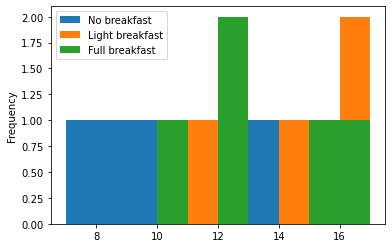

In [5]:
# normality test histogram
exp_df.plot.hist()

In [6]:
# Reform the dataframe 
stack_df = exp_df.stack().reset_index()
stack_df = stack_df.rename(columns={'level_0': 'id',
                                    'level_1': 'treatment',
                                    0:'span'})
display(stack_df)
# show dist
# sns.displot(stack_df, x='span', hue='treatment', kind="kde", fill=True)

,observation,treatment,span
0,0,No breakfast,8
1,0,Light breakfast,14
2,0,Full breakfast,10
3,1,No breakfast,7
4,1,Light breakfast,16
5,1,Full breakfast,12
6,2,No breakfast,9
7,2,Light breakfast,12
8,2,Full breakfast,16
9,3,No breakfast,13


Text(0.5, 1.0, 'Boxplot')

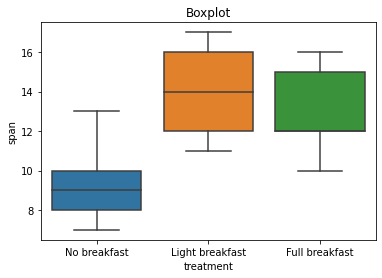

In [7]:
ax = sns.boxplot(y=stack_df["span"], x=stack_df["treatment"])
ax.set_title('Boxplot')

You could use the library below to compute the confidence interval but the best estimate of the common variance uses all information from the entire set of measurements. This is why you should ALWAYS use the POOLED Variance:
variance = s^2 = MSE with df =n - k and Pooled STD = np.sqrt(n) 
The technics below are faster than the one below the analysis of variance table

In [8]:
# THESE METHOD IS FOR SAMPLE DATA (NO SAMPLE MEAN)
import numpy as np
# to check
# Confidence interval
confidence_level = 0.95
# If juste samples (not mean) the dof is 
mean_list, std_list, ci_list = [], [], []
for col_name  in exp_df:
    col_values = exp_df[col_name].values
    sample_size = len(col_values)
    degrees_freedom = sample_size - 1
    sample_mean = np.mean(col_values)
    # Standard error of the mean (SEM) = sigma / sqrt(n)
    sample_standard_error = stats.sem(col_values)
    print('sample_standard_error s^2=', sample_standard_error,
         'or s/np.sqrt(n_t)', np.std(col_values)/np.sqrt(sample_size),  np.std(col_values))
    confidence_interval = stats.t.interval(alpha=confidence_level,
                                           df=degrees_freedom,
                                           loc=sample_mean,
                                           scale=sample_standard_error)
    std_list.append(sample_standard_error)
    ci_list.append(confidence_interval)
    mean_list.append(sample_mean)
    
CI_df = pd.DataFrame([exp_df.columns.values, mean_list, std_list,  ci_list]).transpose()
CI_df.columns = ['treatment',
                 'mean',
                 'std error',
                 'CI']
CI_df.loc[:,'CI'] =  CI_df.loc[:,'CI'].map(lambda x: (x[0].round(2), x[1].round(2)))
CI_df = CI_df.sort_values(by=['mean'])
display(CI_df)


sample_standard_error s^2= 1.0295630140987 or s/np.sqrt(n_t) 0.920869154657707 2.0591260281974
sample_standard_error s^2= 1.1401754250991378 or s/np.sqrt(n_t) 1.019803902718557 2.280350850198276
sample_standard_error s^2= 1.0954451150103321 or s/np.sqrt(n_t) 0.9797958971132711 2.1908902300206643


,treatment,mean,std error,CI
0,No breakfast,9.4,1.02956,"(6.54, 12.26)"
2,Full breakfast,13,1.09545,"(9.96, 16.04)"
1,Light breakfast,14,1.14018,"(10.83, 17.17)"


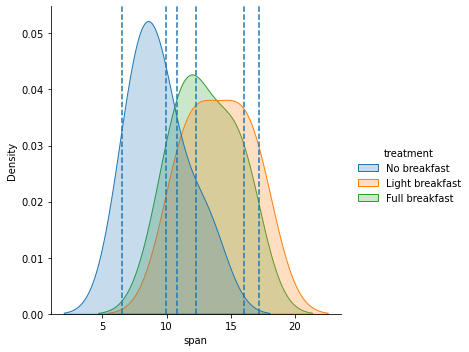

In [9]:
graph = sns.displot(stack_df, x='span', hue='treatment', kind="kde", fill=True)

for CI in CI_df['CI'].values:
    plt.axvline(CI[0],  linestyle='--')
    plt.axvline(CI[1],  linestyle='--')
plt.show()

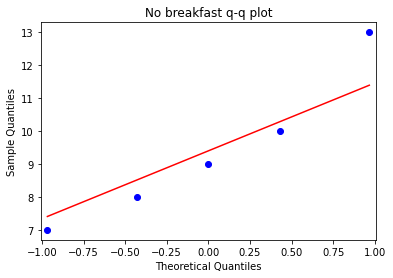

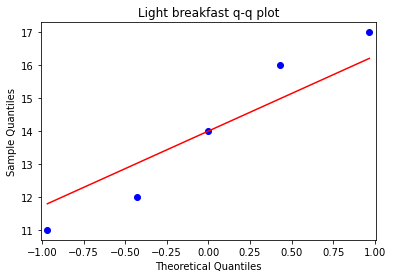

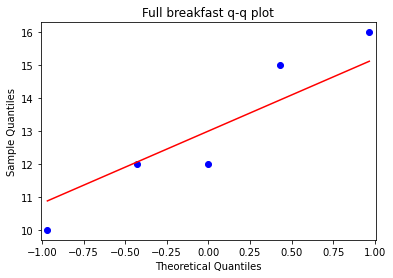

In [10]:
# Normality test quantile-quantile plot.
# Show the theoritical expectation of 
# normal distribution quantile vs present distribution quantile.

from statsmodels.graphics.gofplots import qqplot
for treat in exp_df.columns:
    qqplot(exp_df[treat].values, line='s')
    plt.title(f'{treat} q-q plot')
    plt.show()



In [11]:
# Test hypothesis where null hypothesis assume that the sample are taken from Gaussian
# distribution.
# p <= alpha: reject H0, not normal.
# p > alpha: fail to reject H0, normal.
# Shapiro-Wilk test
from scipy.stats import shapiro
for col, val in exp_df.iteritems():
    print(col)
    stat, p = shapiro(val)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# if p > 0.05 we fail to reject null hypoteshsi -> Gaussian

# Extension, see D’Agostino’s K^2 Test or Anderson-Darling Test

No breakfast
Statistics=0.943, p=0.685
Light breakfast
Statistics=0.944, p=0.692
Full breakfast
Statistics=0.925, p=0.563


In [12]:
# Levene test for homogeneity of variance
stats.levene(*[exp_df[treat] for treat in exp_df.columns])
# if p-value >0.05 non-statistically significant difference in their varability

LeveneResult(statistic=0.08571428571428566, pvalue=0.9184132649741406)

In [13]:
# ANOVA one way
import scipy.stats as stats

F, p = stats.f_oneway(*[exp_df[treat] for treat in exp_df.columns])


print(f'F= {F}, p={p}')
# Interpretation
# F_stat = 4.9 to compare with critical value of test statistic F_alpha
# p-value = 0.027 < 0.05 we can say at 95% of confidence that
# breakfast load has an effect on attention span. 


F= 4.93258426966292, p=0.02732564994828438


In [19]:
# ANOVA the hard way
# n1 = n2 = n3 
k = len(exp_df.iloc[0]) # Number of columns
list_n = exp_df.count().values
n = np.sum(exp_df.count().values) # Total number of observations

# sum all value from all groups and divide it by sum of observation from all (the three) samples
CM = (exp_df.sum().sum())**2 / n 
# print('CM', CM)
# total SS 
TSS = (exp_df**2).sum().sum() - CM
dof_tss = n - 1

# SST between
SST = ((exp_df.sum()**2).values / list_n).sum() - CM
dof_sst = k - 1
MST = SST / dof_sst 
# SSE within
SSE = TSS - SST
dof_mse = n - k
MSE = SSE / dof_mse

# Test statistic
F = MST/ MSE
# p-value
p = stats.f.sf(F, dof_sst, dof_mse)

# Eta 
et_sq = SST / TSS
# Omega squared 
om_sq = SST - (dof_sst * MSE) / (TSS + MSE)

print('SST', SST, 'dof', dof_sst,'MST', MST)
print('SSE', SSE, 'dof', dof_mse,'MSE', MSE)
print('TSS', TSS, 'dof', dof_tss, 'F', F)
print('p value', p)
print('eta squared', et_sq, 'omega_sqaured', om_sq)


SST 58.5333333333333 dof 2 MST 29.26666666666665
SSE 71.19999999999982 dof 12 MSE 5.9333333333333185
TSS 129.73333333333312 dof 14 F 4.932584269662931
p value 0.027325649948284212
eta squared 0.4511819116135668 omega_sqaured 58.44586404586401


In [20]:
alpha = 0.05
F_alpha = stats.f.ppf(q=1-alpha, dfn=dof_sst, dfd=dof_mse)
F_alpha

3.8852938346523933

In [21]:
# CHECK THE RESULTS of DF in analys variance table.
# F stat and pvalue from statsmodel
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Reform the dataframe 
stack_df = exp_df.stack().reset_index()
stack_df = stack_df.rename(columns={'level_0': 'id',
                                    'level_1': 'treatment',
                                    0:'span'})
# print(exp_df_2)

mod = ols('span ~ treatment', data=stack_df).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

# et_sq = SST / TSS
et_sq = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
print('et_sq', et_sq)

              sum_sq    df         F    PR(>F)
treatment  58.533333   2.0  4.932584  0.027326
Residual   71.200000  12.0       NaN       NaN
et_sq 0.45118191161356613


In [22]:
# confidence interval for the difference of one means
mean0 = exp_df.mean()[0]
var = MSE
s = np.sqrt(var)
# from t distribution at 95% LOC and df = n-k = 15-3 = 12
t_alpha = 2.179
CI = t_alpha * s * np.sqrt(1/5)
print('CI for no breakfast:',  mean0 - CI, mean0 + CI)

# confidence interval for the difference of two means
mean1 = exp_df.mean()[1]
mean2 = exp_df.mean()[2]
var = MSE
diff_mean = mean1-mean2
# from t distribution at 95% LOC and df = n-k = 15-3 = 12
t_alpha = 2.179
CI = t_alpha * s *  np.sqrt((1/5) + (1/5))
print('CI light VS full:',  diff_mean - CI, diff_mean + CI)

CI for no breakfast: 7.026323108199717 11.773676891800283
CI light VS full: -2.3568860530755735 4.3568860530755735


In [23]:
# Tukey multi comparison method
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(stack_df['span'],
                            stack_df['treatment'])

# Show all pair-wise comparisons:

# Print the comparisons

print(MultiComp.tukeyhsd().summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------
 Full breakfast Light breakfast      1.0 0.7856 -3.108  5.108  False
 Full breakfast    No breakfast     -3.6 0.0885 -7.708  0.508  False
Light breakfast    No breakfast     -4.6 0.0283 -8.708 -0.492   True
--------------------------------------------------------------------


In [24]:
# Confidence intervals

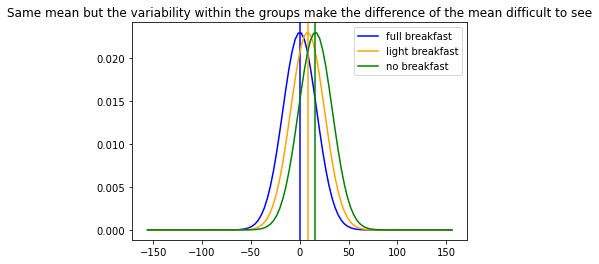

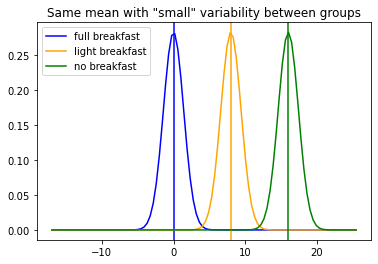

In [29]:
import math
import numpy as np

mu = 0
variance = 300
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma*3, mu + 3*sigma*3, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='blue', label='full breakfast')
plt.axvline(mu, color='blue')

mu2 = mu+8
plt.plot(x, stats.norm.pdf(x, mu2, sigma), color='orange', label='light breakfast')
plt.axvline(mu2, color='orange')

mu3 = mu+16
plt.plot(x, stats.norm.pdf(x, mu3, sigma), color='green', label='no breakfast')
plt.axvline(mu3, color='green')
plt.title('Same mean but the variability within the groups make the difference of the mean difficult to see')
plt.legend()
plt.show()


mu = 0
variance = 2
sigma = math.sqrt(variance)
x = np.linspace(mu - 4*sigma*3, mu + 6*sigma*3, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='blue', label='full breakfast')
plt.axvline(mu, color='blue')

mu2 = mu+8
plt.plot(x, stats.norm.pdf(x, mu2, sigma), color='orange', label='light breakfast')
plt.axvline(mu2, color='orange')
plt.title('Same mean with "small" variability between groups')

mu3 = mu+16
plt.plot(x, stats.norm.pdf(x, mu3, sigma), color='green', label='no breakfast')
plt.axvline(mu3, color='green')
plt.legend()
plt.show()
